# Data Augmentation

In [22]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real'

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


# Model 1 (Resnet Original)

In [25]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [27]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [29]:
initial_epochs = 30

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
26/26 [==============================] - 12s 314ms/step - loss: 1.7023 - mae: 1.0605 - val_loss: 1.3141 - val_mae: 0.9347
Epoch 2/30
26/26 [==============================] - 8s 271ms/step - loss: 1.2626 - mae: 0.9311 - val_loss: 1.1675 - val_mae: 0.8822
Epoch 3/30
26/26 [==============================] - 7s 270ms/step - loss: 1.1063 - mae: 0.8672 - val_loss: 1.0266 - val_mae: 0.8236
Epoch 4/30
26/26 [==============================] - 7s 270ms/step - loss: 0.9779 - mae: 0.8152 - val_loss: 0.9401 - val_mae: 0.7819
Epoch 5/30
26/26 [==============================] - 7s 271ms/step - loss: 0.8826 - mae: 0.7736 - val_loss: 0.9182 - val_mae: 0.7726
Epoch 6/30
26/26 [==============================] - 8s 274ms/step - loss: 0.8101 - mae: 0.7435 - val_loss: 0.8478 - val_mae: 0.7364
Epoch 7/30
26/26 [==============================] - 8s 273ms/step - loss: 0.7524 - mae: 0.7164 - val_loss: 0.8068 - val_mae: 0.7090
Epoch 8/30
26/26 [==============================] - 7s 272ms/step - loss: 0

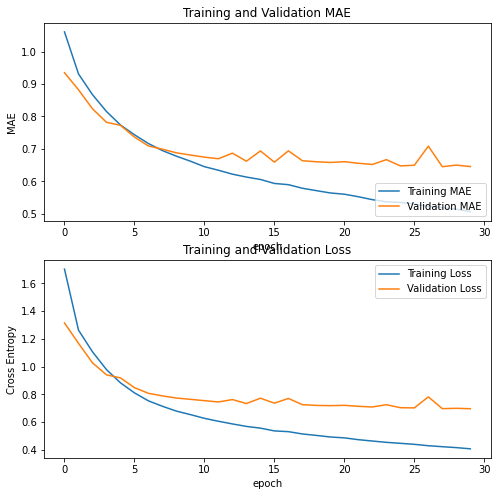

In [30]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 (Resnet with Filtered Data)

In [31]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real_filtered2'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


In [32]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [34]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
initial_epochs = 30

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
26/26 [==============================] - 104s 4s/step - loss: 1.3997 - mae: 0.9665 - val_loss: 1.3094 - val_mae: 0.9527
Epoch 2/30
26/26 [==============================] - 8s 273ms/step - loss: 1.1443 - mae: 0.8813 - val_loss: 1.1889 - val_mae: 0.8984
Epoch 3/30
26/26 [==============================] - 7s 268ms/step - loss: 1.0190 - mae: 0.8325 - val_loss: 1.0663 - val_mae: 0.8436
Epoch 4/30
26/26 [==============================] - 7s 270ms/step - loss: 0.9213 - mae: 0.7872 - val_loss: 0.9943 - val_mae: 0.8092
Epoch 5/30
26/26 [==============================] - 8s 274ms/step - loss: 0.8535 - mae: 0.7597 - val_loss: 0.9815 - val_mae: 0.8037
Epoch 6/30
26/26 [==============================] - 7s 270ms/step - loss: 0.7982 - mae: 0.7315 - val_loss: 0.9485 - val_mae: 0.7882
Epoch 7/30
26/26 [==============================] - 7s 271ms/step - loss: 0.7584 - mae: 0.7117 - val_loss: 0.8965 - val_mae: 0.7609
Epoch 8/30
26/26 [==============================] - 8s 272ms/step - loss: 0.7

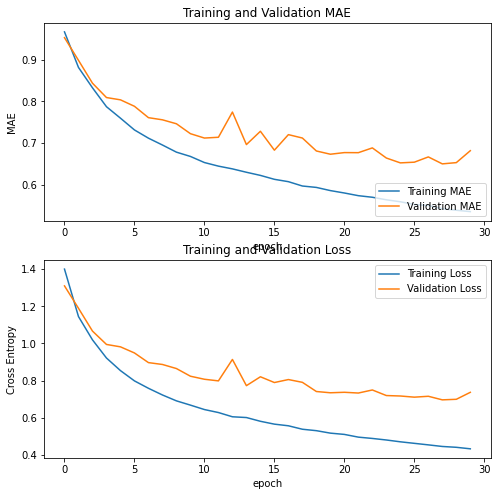

In [37]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()